<a href="https://colab.research.google.com/github/Oumayma-O/prompt_classifier_notebook/blob/main/prompt_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.10.12


In [ ]:
import sklearn
print(sklearn.__version__)


1.2.2


# Importing packages

In [ ]:
%pip install scikit-learn

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer # convertire text -> TF-IDF
from sklearn.model_selection import train_test_split # split data
from sklearn.linear_model import LogisticRegression # regressiong classifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import spacy
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import joblib


# Importing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to your CSV file
csv_file_path = '/content/drive/MyDrive/Prompt-classifier/data.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Remove rows with the 'output' label in the 'output' column
df = df[df['output'] != 'output']

In [ ]:
df.head()

,input,output
0,je cherche un emploi de développeur web en remote,best_jobs
1,recommandation pour trouver un poste de data s...,best_jobs
2,comment rédiger un CV efficace pour un poste d...,cv_improver
3,avis sur mon CV pour postuler comme ingénieur ...,cv_improver
4,peut-on améliorer mon CV pour un emploi de dév...,cv_improver


# EDA

In [ ]:
# Step 4: Visualize the head of the DataFrame
print("Head of the DataFrame:")
print(df.head())

Head of the DataFrame:
                                               input       output
0  je cherche un emploi de développeur web en remote    best_jobs
1  recommandation pour trouver un poste de data s...    best_jobs
2  comment rédiger un CV efficace pour un poste d...  cv_improver
3  avis sur mon CV pour postuler comme ingénieur ...  cv_improver
4  peut-on améliorer mon CV pour un emploi de dév...  cv_improver


In [ ]:
# Step 5: Show dataset description
print("\nDataset Description:")
print(df.describe(include='all'))


Dataset Description:
                                                    input              output
count                                                 396                 396
unique                                                171                   5
top     avis sur ma lettre de motivation pour une offr...  interview-coaching
freq                                                    5                 105


In [ ]:
# Check for duplicates
duplicates = df.duplicated()
num_duplicates = duplicates.sum()

# Print the number of duplicates
print(f'Number of duplicate rows: {num_duplicates}')


Number of duplicate rows: 225


In [ ]:
# Remove duplicates
df = df.drop_duplicates()

# Optionally, save the cleaned DataFrame back to a CSV file
df.to_csv('cleaned_csv_file_path.csv', index=False)

In [ ]:
# Step 6: Summary of the DataFrame
print("\nDataFrame Summary:")
print(df.info())


DataFrame Summary:
<class 'pandas.core.frame.DataFrame'>
Index: 171 entries, 0 to 395
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   171 non-null    object
 1   output  171 non-null    object
dtypes: object(2)
memory usage: 4.0+ KB
None



Class Distribution:
output
KO                    51
interview-coaching    37
cv_improver           32
lm_improver           26
best_jobs             25
Name: count, dtype: int64


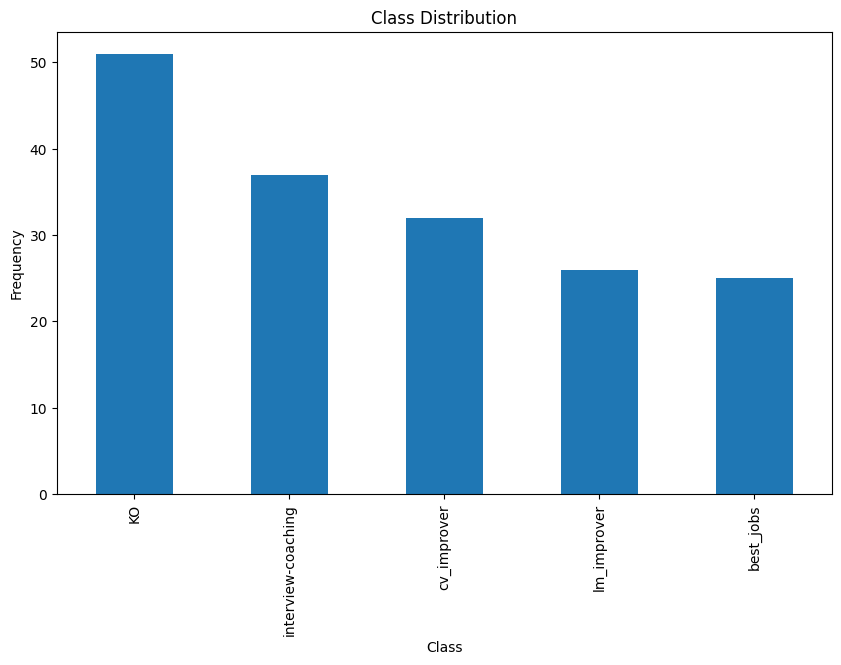

In [ ]:
# Step 7: Print and plot class distribution
if 'output' in df.columns:
    class_counts = df['output'].value_counts()
    print("\nClass Distribution:")
    print(class_counts)

    # Plotting class distribution
    plt.figure(figsize=(10, 6))
    class_counts.plot(kind='bar')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("The dataset does not contain a 'output'.")

In [ ]:
# Calculate the length of each input
df['input_length'] = df['input'].apply(len)

In [ ]:
df.head()

,input,output,input_length
0,je cherche un emploi de développeur web en remote,best_jobs,49
1,recommandation pour trouver un poste de data s...,best_jobs,62
2,comment rédiger un CV efficace pour un poste d...,cv_improver,72
3,avis sur mon CV pour postuler comme ingénieur ...,cv_improver,61
4,peut-on améliorer mon CV pour un emploi de dév...,cv_improver,60


In [ ]:
# Group by 'output' and calculate the average input length
average_length_per_class = df.groupby('output')['input_length'].mean()

# Print the average lengths
print("\nAverage Input Length per Class:")
print(average_length_per_class)


Average Input Length per Class:
output
KO                     43.960784
best_jobs              91.000000
cv_improver            87.937500
interview-coaching    121.972973
lm_improver            97.615385
Name: input_length, dtype: float64


# Data Augmentation

In [ ]:
pip install nltk googletrans==4.0.0-rc1 imbalanced-learn


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 7.8 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17395 sha256=029f31decd4217f1279c5caf82a4dd622dac469b92fa687ad98fab110042a88b
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling 

In [ ]:
import pandas as pd
import random
from nltk.corpus import wordnet
from googletrans import Translator
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

# Download NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Synonym replacement function for French
def synonym_replacement_french(text):
    words = text.split()
    new_words = words.copy()
    for i, word in enumerate(words):
        synonyms = wordnet.synsets(word, lang='fra')
        if synonyms:
            synonym = synonyms[0].lemmas(lang='fra')[0].name()
            if synonym != word:
                new_words[i] = synonym
    return ' '.join(new_words)


In [ ]:
# Back translation function
def back_translation_french(text, src='fr', mid='en'):
    translator = Translator()
    translated = translator.translate(text, src=src, dest=mid).text
    back_translated = translator.translate(translated, src=mid, dest=src).text
    return back_translated


In [ ]:
# Function to augment data
def augment_data(df, target_label, n_samples):
    df_class = df[df['output'] == target_label]
    augmented_texts = df_class['input'].tolist()

    while len(augmented_texts) < n_samples:
        for text in df_class['input']:
            if len(augmented_texts) >= n_samples:
                break
            augmented_texts.append(synonym_replacement_french(text))
            if len(augmented_texts) >= n_samples:
                break
            augmented_texts.append(back_translation_french(text))

    augmented_df = pd.DataFrame({'input': augmented_texts[:n_samples], 'output': [target_label] * n_samples})
    return augmented_df

In [ ]:
# Apply data augmentation to each class
target_samples_per_class = 200
augmented_dfs = []

for label in df['output'].unique():
    augmented_df = augment_data(df, label, target_samples_per_class)
    augmented_dfs.append(augmented_df)

# Combine all augmented dataframes
df_augmented = pd.concat(augmented_dfs)

In [ ]:
# Save the combined dataframe to Google Drive
df_augmented.to_csv('/content/drive/MyDrive/Prompt-classifier/augmented_data.csv', index=False)

In [ ]:
# Display the new data summary
print("New Data Summary:")
print(df_augmented.info())
print("\nClass Distribution after Augmentation:")
print(df_augmented['output'].value_counts())


New Data Summary:
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   1000 non-null   object
 1   output  1000 non-null   object
dtypes: object(2)
memory usage: 23.4+ KB
None

Class Distribution after Augmentation:
output
best_jobs             200
cv_improver           200
lm_improver           200
interview-coaching    200
KO                    200
Name: count, dtype: int64


In [ ]:
# Separate features and target
X = df_augmented['input']
y = df_augmented['output']

# Adding a preprocessing layer

In [ ]:
!pip install spacy
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 48.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import spacy
import re

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Load SpaCy model for French
nlp = spacy.load('fr_core_news_sm')

# Function to resolve contractions using SpaCy
def resolve_contractions_spacy(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return ' '.join(tokens)

# Basic text cleaning function with POS tagging and lemmatization we can remove single characters too
def preprocess_text(text):
    # Resolve contractions
    text = resolve_contractions_spacy(text)
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Process text with SpaCy for tokenization, POS tagging, and lemmatization
    doc = nlp(text)
    # Remove stopwords and perform lemmatization
    french_stopwords = set(stopwords.words('french'))
    words = [token.lemma_ for token in doc if token.text not in french_stopwords and token.pos_ != 'PUNCT']
    # Rejoin words into a single string
    cleaned_text = ' '.join(words)
    # Remove trailing spaces and multiple spaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

# Example usage
text_example = "Je cherche un emploi de développeur web en remote."
cleaned_text = preprocess_text(text_example)
print(cleaned_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


cherche emploi développeur web remote


In [ ]:
# Apply text preprocessing
df_augmented['input'] = df_augmented['input'].apply(preprocess_text)

In [ ]:
# Save the combined dataframe to Google Drive
df_augmented.to_csv('/content/drive/MyDrive/Prompt-classifier/preprocessed_augmented_data.csv', index=False)

In [ ]:
# Display the head of the DataFrame after preprocessing
print("Head of the DataFrame after preprocessing:")
print(df_augmented.head())

Head of the DataFrame after preprocessing:
                                               input     output
0              cherche emploi développeur web remote  best_jobs
1  recommandation trouver poste dater scientist pari  best_jobs
2  recherche opportunité tant analyste financier ...  best_jobs
3           conseil trouver emploi marketing digital  best_jobs
4           conseil postuler emploi développeur java  best_jobs


#TF-IDF Vectorization

In [ ]:
csv_file_path = '/content/drive/MyDrive/Prompt-classifier/augmented_data.csv'

# Read the CSV file into a DataFrame
df_augmented = pd.read_csv(csv_file_path)

In [ ]:
# Feature Engineering - TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df_augmented['input'])

In [ ]:
y = df_augmented['output']

In [ ]:
# Convert the TF-IDF matrix to a DataFrame (for inspecting the terms, if needed)
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

In [ ]:
tfidf_df.head()

,2024,aboutir,acquarossa,adapter,administrateur,administration,administrer,adopter,affiler,affre,...,voiture,voyage,web,économiser,écrire,énergie,étape,évidence,événement,événementiel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.519073,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Check for duplicate index labels in the DataFrame
print("Checking for duplicate index labels...")
if tfidf_df.index.duplicated().any():
    print("Duplicate index labels found. Resetting index...")
    tfidf_df.reset_index(drop=True, inplace=True)

# Ensure that the length of y matches the length of tfidf_df
if len(tfidf_df) != len(y):
    raise ValueError(f"Length of tfidf_df ({len(tfidf_df)}) does not match length of y ({len(y)})")


Checking for duplicate index labels...


In [ ]:
# Reset index of y to match tfidf_df if necessary
y = y.reset_index(drop=True)

# Add the 'output' column to the TF-IDF DataFrame
tfidf_df['output'] = y

# Show the most frequent terms for each class
most_frequent_terms = {}
for class_label in tfidf_df['output'].unique():
    class_df = tfidf_df[tfidf_df['output'] == class_label]
    term_sums = class_df.drop(columns=['output']).sum().sort_values(ascending=False)
    most_frequent_terms[class_label] = term_sums.head(10)

print("\nMost Frequent Terms for Each Class:")
for class_label, terms in most_frequent_terms.items():
    print(f"\nClass: {class_label}")
    print(terms)


Most Frequent Terms for Each Class:

Class: best_jobs
opportunité    32.118309
emploi         19.220946
après          14.504457
enquête        14.431470
meilleur       14.427537
logiciel       13.782175
ingénieur      13.071138
débutant       12.812467
analyste       12.162033
recherche      11.935064
dtype: float64

Class: cv_improver
cv                42.197926
continuer         16.684182
poste             15.302455
comment           14.370936
compétence        14.259807
inégalable        13.261017
recommandation    12.827447
développeur       12.063638
projet            11.165841
adapter            9.963091
dtype: float64

Class: lm_improver
lettre           46.774474
motivation       34.164906
besoin           30.895882
continuer        26.939520
an               21.973545
opinion          15.951743
affiler          14.724430
communication    12.824551
après            11.544571
offre            11.179813
dtype: float64

Class: interview-coaching
entretien      39.134820
inégalab

# Splitting data

In [ ]:
# Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
y_train.shape

(800,)

In [ ]:
y_train_series = pd.Series(y_train)
train_class_counts = y_train_series.value_counts()

print("\nTraining Data Class Distribution:")
print(train_class_counts)


Training Data Class Distribution:
output
best_jobs             167
lm_improver           163
interview-coaching    162
KO                    156
cv_improver           152
Name: count, dtype: int64


In [ ]:
y_test_series = pd.Series(y_test)
test_class_counts = y_test_series.value_counts()

print("\nTesting Data Class Distribution:")
print(test_class_counts)


Testing Data Class Distribution:
output
cv_improver           48
KO                    44
interview-coaching    38
lm_improver           37
best_jobs             33
Name: count, dtype: int64


# LogisticRegression ovr scheme

In [ ]:
model = LogisticRegression(multi_class='ovr', solver='liblinear')  # One-vs-Rest scheme for multi-class classification

## Training model

In [ ]:
model.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

## Model Evaluation


Classification Report:
                    precision    recall  f1-score   support

                KO       1.00      1.00      1.00        44
         best_jobs       1.00      1.00      1.00        33
       cv_improver       1.00      1.00      1.00        48
interview-coaching       1.00      1.00      1.00        38
       lm_improver       1.00      1.00      1.00        37

          accuracy                           1.00       200
         macro avg       1.00      1.00      1.00       200
      weighted avg       1.00      1.00      1.00       200


Accuracy Score:
1.0


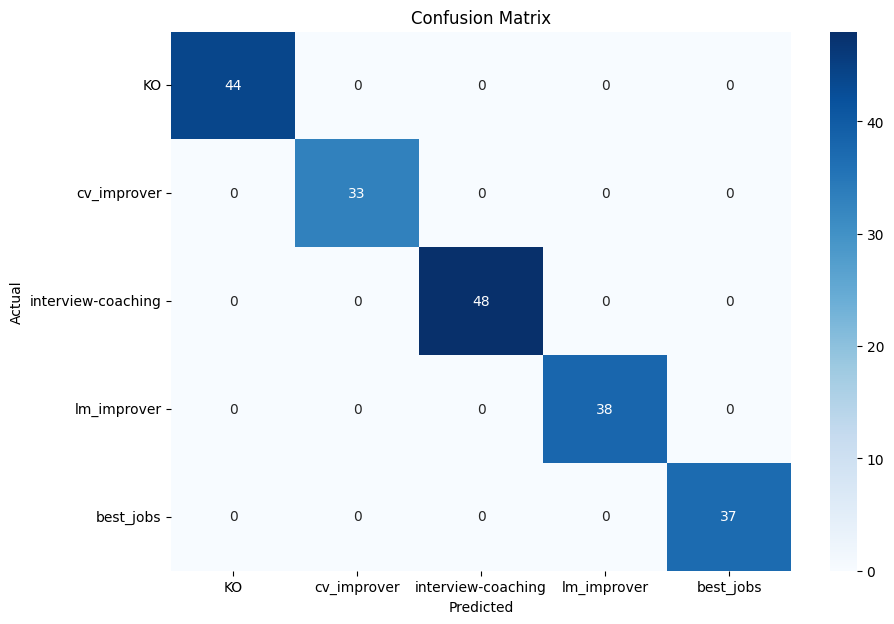

In [ ]:
# Model Evaluation
y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


print("\nAccuracy Score:")
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_counts.index, yticklabels=class_counts.index)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Logistic Regression (Softmax)

In [ ]:
# Multinomial Logistic Regression (Softmax)
model_softmax = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model_softmax.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

In [ ]:
# Save the trained model to a file
model_filename = '/content/drive/MyDrive/Prompt-classifier/softmax_model.joblib'
joblib.dump(model_softmax, model_filename)

print(f"Model saved to {model_filename}")

Model saved to /content/drive/MyDrive/Prompt-classifier/softmax_model.joblib


## Model Evaluation


Softmax Classification Report:
                    precision    recall  f1-score   support

                KO       1.00      1.00      1.00        44
         best_jobs       1.00      1.00      1.00        33
       cv_improver       1.00      1.00      1.00        48
interview-coaching       1.00      1.00      1.00        38
       lm_improver       1.00      1.00      1.00        37

          accuracy                           1.00       200
         macro avg       1.00      1.00      1.00       200
      weighted avg       1.00      1.00      1.00       200


Confusion Matrix:
[[44  0  0  0  0]
 [ 0 33  0  0  0]
 [ 0  0 48  0  0]
 [ 0  0  0 38  0]
 [ 0  0  0  0 37]]

Accuracy Score:
1.0


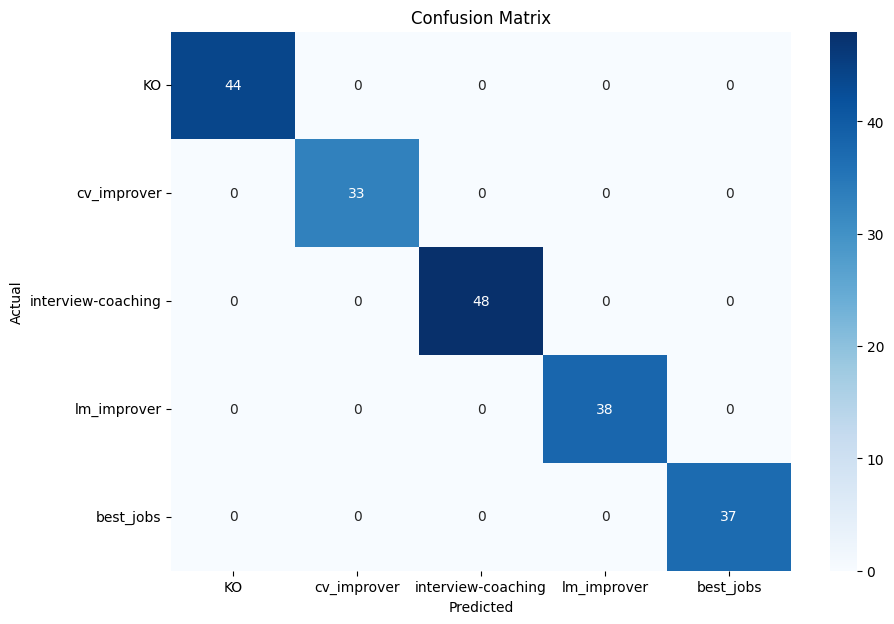

In [ ]:
# Model Evaluation
y_pred_softmax = model_softmax.predict(X_test)

print("\nSoftmax Classification Report:")
print(classification_report(y_test, y_pred_softmax))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred_softmax)
print(conf_matrix)

print("\nAccuracy Score:")
accuracy = accuracy_score(y_test, y_pred_softmax)
print(accuracy)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_counts.index, yticklabels=class_counts.index)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Prediction on random sample

In [ ]:
model_filename = '/content/drive/MyDrive/Prompt-classifier/softmax_model.joblib'
model = joblib.load(model_filename)
print("Model loaded successfully")

Model loaded successfully


In [ ]:
# Function to predict class for input prompt
def predict_class(input_text):
    # Preprocess text
    input_text_processed = preprocess_text(input_text)
    # Vectorize input text
    input_text_tfidf = vectorizer.transform(input_text_processed)
    # Predict class
    predicted_class = model.predict(input_text_tfidf)
    return predicted_class[0]

In [ ]:
input_prompt = "élaborer une lettre de motivation pour un VIE à l'étranger"
predicted_class = predict_class(input_prompt)
print("Predicted class:", predicted_class)

Predicted class: lm_improver


# Multi-label classification

## Data preparation

In [ ]:
# Path to your CSV file
csv_file_path = '/content/drive/MyDrive/Prompt-classifier/augmented_data.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)


Class Distribution:
output
best_jobs             200
cv_improver           200
lm_improver           200
interview-coaching    200
KO                    200
Name: count, dtype: int64


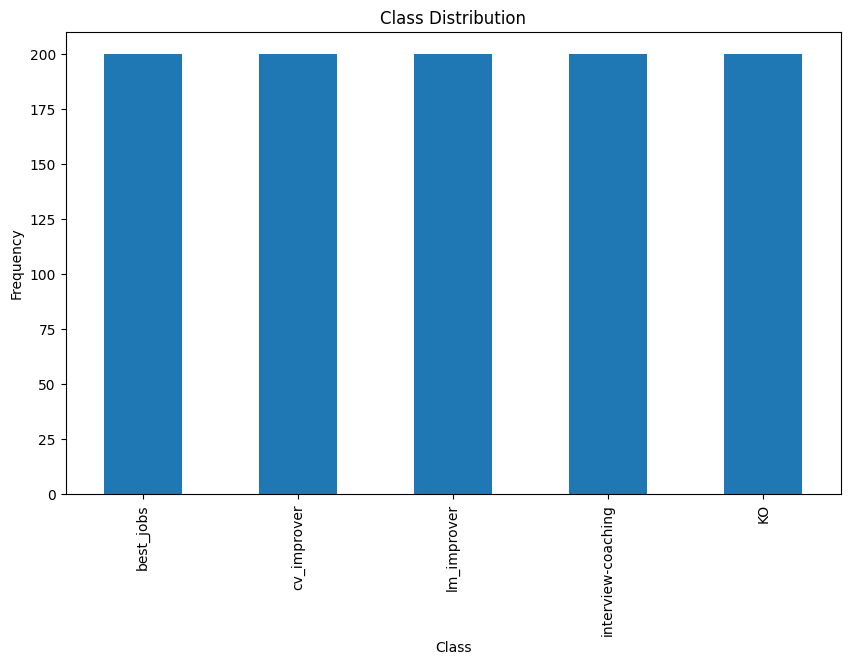

In [ ]:
# Step 7: Print and plot class distribution
if 'output' in df.columns:
    class_counts = df['output'].value_counts()
    print("\nClass Distribution:")
    print(class_counts)

    # Plotting class distribution
    plt.figure(figsize=(10, 6))
    class_counts.plot(kind='bar')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("The dataset does not contain a 'output'.")

In [ ]:
# Add new columns
df['best_jobs'] = 0
df['cv_improver'] = 0
df['lm_improver'] = 0
df['interview-coaching'] = 0
df['KO'] = 0

In [ ]:
df.head()

,input,output,best_jobs,cv_improver,lm_improver,interview-coaching,KO
0,je cherche un emploi de développeur web en remote,best_jobs,0,0,0,0,0
1,recommandation pour trouver un poste de data s...,best_jobs,0,0,0,0,0
2,recherche d'opportunités en tant qu'analyste f...,best_jobs,0,0,0,0,0
3,conseils pour trouver un emploi en marketing d...,best_jobs,0,0,0,0,0
4,conseils pour postuler à un emploi de développ...,best_jobs,0,0,0,0,0


In [ ]:
df.loc[df['output'] == 'best_jobs', 'best_jobs'] = 1
df.loc[df['output'] == 'cv_improver', 'cv_improver'] = 1
df.loc[df['output'] == 'lm_improver', 'lm_improver'] = 1
df.loc[df['output'] == 'interview-coaching', 'interview-coaching'] = 1
df.loc[df['output'] == 'KO', 'KO'] = 1

In [ ]:
df.head()

,input,output,best_jobs,cv_improver,lm_improver,interview-coaching,KO
0,je cherche un emploi de développeur web en remote,best_jobs,1,0,0,0,0
1,recommandation pour trouver un poste de data s...,best_jobs,1,0,0,0,0
2,recherche d'opportunités en tant qu'analyste f...,best_jobs,1,0,0,0,0
3,conseils pour trouver un emploi en marketing d...,best_jobs,1,0,0,0,0
4,conseils pour postuler à un emploi de développ...,best_jobs,1,0,0,0,0


In [ ]:
# Save the combined dataframe to Google Drive
df.to_csv('/content/drive/MyDrive/Prompt-classifier/edited_preprocessed_data.csv', index=False)

In [ ]:
# Verify assignments
print("Class Distribution for 'best_jobs':")
print(df['best_jobs'].value_counts())
print("Class Distribution for 'cv_improver':")
print(df['cv_improver'].value_counts())
print("Class Distribution for 'lm_improver':")
print(df['lm_improver'].value_counts())
print("Class Distribution for 'interview_coaching':")
print(df['interview-coaching'].value_counts())
print("Class Distribution for 'ko':")
print(df['KO'].value_counts())


Class Distribution for 'best_jobs':
best_jobs
0    800
1    200
Name: count, dtype: int64
Class Distribution for 'cv_improver':
cv_improver
0    800
1    200
Name: count, dtype: int64
Class Distribution for 'lm_improver':
lm_improver
0    800
1    200
Name: count, dtype: int64
Class Distribution for 'interview_coaching':
interview-coaching
0    800
1    200
Name: count, dtype: int64
Class Distribution for 'ko':
KO
0    800
1    200
Name: count, dtype: int64


In [ ]:
# Data augmentation function
def augment_data(df, target_class='best_jobs'):
    # Identify the minority class
    minority_class_label = 1

    # Get the data for the minority class
    minority_data = df[df[target_class] == minority_class_label]

    # Define the number of samples you want to augment
    majority_class_size = df[target_class].value_counts().max()
    num_samples_to_augment = majority_class_size - len(minority_data)

    # Augment the data to balance the class distribution
    augmented_samples = []
    while len(augmented_samples) < num_samples_to_augment:
        for index, row in minority_data.iterrows():
            if len(augmented_samples) >= num_samples_to_augment:
                break
            augmented_text = synonym_replacement_french(row['input'])
            augmented_samples.append({'input': augmented_text, target_class: minority_class_label})
            if len(augmented_samples) >= num_samples_to_augment:
                break
            augmented_text = back_translation_french(row['input'])
            augmented_samples.append({'input': augmented_text, target_class: minority_class_label})

    # Convert the list of augmented samples to a DataFrame
    augmented_df = pd.DataFrame(augmented_samples)

    # Concatenate the augmented data with the original dataset
    balanced_df = pd.concat([df, augmented_df], ignore_index=True)

    # Shuffle the DataFrame to ensure randomness
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_df

## Best-Job binary logistic regression classifier

In [ ]:
# Check the class distribution
class_distribution = df['best_jobs'].value_counts()
print(class_distribution)

best_jobs
0    800
1    200
Name: count, dtype: int64


In [ ]:
# Balance the dataset using data augmentation
balanced_df_bj = augment_data(df, target_class='best_jobs')

In [ ]:
# Save the combined dataframe to Google Drive
balanced_df_bj.to_csv('/content/drive/MyDrive/Prompt-classifier/balanced_df_bj.csv', index=False)

In [ ]:
# Check the class distribution
class_distribution = balanced_df_bj['best_jobs'].value_counts()
print(class_distribution)

best_jobs
0    800
1    800
Name: count, dtype: int64


In [ ]:
# Apply text preprocessing
balanced_df_bj['input'] = balanced_df_bj['input'].apply(preprocess_text)

In [ ]:
# Save the combined dataframe to Google Drive
balanced_df_bj.to_csv('/content/drive/MyDrive/Prompt-classifier/df_bj.csv', index=False)

In [ ]:
# Display the head of the DataFrame after preprocessing
print("Head of the DataFrame after preprocessing:")
balanced_df_bj.head()

Head of the DataFrame after preprocessing:


,input,output,best_jobs,cv_improver,lm_improver,interview-coaching,KO
0,bonjour vouloir avoir lettre continuer besoin ...,lm_improver,0,0.0,1.0,0.0,0.0
1,bonjour peu jet inégalable oeil maturité cv ma...,cv_improver,0,1.0,0.0,0.0,0.0
2,bonjour recherche offre emploi chef produit ma...,best_jobs,1,0.0,0.0,0.0,0.0
3,enquête opportunité après cruellemer cependant...,best_jobs,1,0.0,0.0,0.0,0.0
4,quel dernier film maturité voir absolument ce ...,KO,0,0.0,0.0,0.0,1.0


In [ ]:
# Path to your CSV file
csv_file_path = '/content/drive/MyDrive/Prompt-classifier/df_bj.csv'

# Read the CSV file into a DataFrame
balanced_df_bj = pd.read_csv(csv_file_path)

In [ ]:
# Features and target variable for the 'best_jobs' class
X_bj = balanced_df_bj['input']
y_bj= balanced_df_bj['best_jobs']

# Split the data into training and testing sets
X_train_bj, X_test_bj, y_train_bj, y_test_bj = train_test_split(X_bj, y_bj, test_size=0.2, random_state=42)

# Convert text data into numerical features using TfidfVectorizer
tfidf_bj = TfidfVectorizer()
X_train_bj_tfidf = tfidf_bj.fit_transform(X_train_bj)
X_test_bj_tfidf = tfidf_bj.transform(X_test_bj)

# Train the logistic regression model
log_reg_best_jobs = LogisticRegression()
log_reg_best_jobs.fit(X_train_bj_tfidf, y_train_bj)

# Predict on the test set
y_pred_bj= log_reg_best_jobs.predict(X_test_bj_tfidf)

# Evaluate the model
print(classification_report(y_test_bj, y_pred_bj))

# Print the class distribution after augmentation
print("Class distribution after augmentation:", Counter(y_train_bj))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       154
           1       1.00      1.00      1.00       166

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320

Class distribution after augmentation: Counter({0: 646, 1: 634})



Confusion Matrix:
[[154   0]
 [  0 166]]

Accuracy Score:
1.0


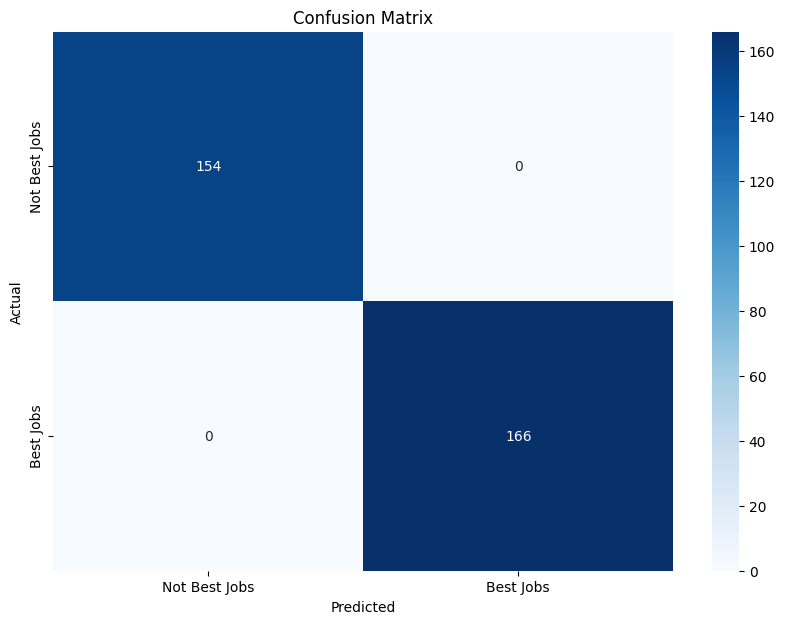

In [ ]:
# Confusion matrix and accuracy score
conf_matrix = confusion_matrix(y_test_bj, y_pred_bj)
accuracy = accuracy_score(y_test_bj, y_pred_bj)

print("\nConfusion Matrix:")
print(conf_matrix)

print("\nAccuracy Score:")
print(accuracy)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Best Jobs', 'Best Jobs'], yticklabels=['Not Best Jobs', 'Best Jobs'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Define the paths
model_path = '/content/drive/MyDrive/Prompt-classifier/log_reg_best_jobs_model.joblib'
vectorizer_path = '/content/drive/MyDrive/Prompt-classifier/tfidf_vectorizer_bj.joblib'

# Save the model and vectorizer
joblib.dump(log_reg_best_jobs, model_path)
joblib.dump(tfidf_bj, vectorizer_path)

print("Model and vectorizer saved successfully in joblib format.")

Model and vectorizer saved successfully in joblib format.


## cv-improver binary logistic regression classifier

In [ ]:
# Check the class distribution
class_distribution = df['cv_improver'].value_counts()
print(class_distribution)

cv_improver
0    800
1    200
Name: count, dtype: int64


In [ ]:
# Balance the dataset using data augmentation
balanced_df_cv = augment_data(df, target_class='cv_improver')

In [ ]:
# Check the class distribution
class_distribution = balanced_df_cv['cv_improver'].value_counts()
print(class_distribution)

cv_improver
0    800
1    800
Name: count, dtype: int64


In [ ]:
# Apply text preprocessing
balanced_df_cv['input'] = balanced_df_cv['input'].apply(preprocess_text)

In [ ]:
# Save the preprocessed dataframe to Google Drive
balanced_df_cv.to_csv('/content/drive/MyDrive/Prompt-classifier/df_cv.csv', index=False)

In [ ]:
# Path to your CSV file
csv_file_path = '/content/drive/MyDrive/Prompt-classifier/df_cv.csv'

# Read the CSV file into a DataFrame
balanced_df_cv = pd.read_csv(csv_file_path)

In [ ]:
# Features and target variable for the 'best_jobs' class
X_cv = balanced_df_cv['input']
y_cv= balanced_df_cv['cv_improver']

# Split the data into training and testing sets
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_cv, y_cv, test_size=0.2, random_state=42)

# Convert text data into numerical features using TfidfVectorizer
tfidf_cv = TfidfVectorizer()
X_train_cv_tfidf = tfidf_cv.fit_transform(X_train_cv)
X_test_cv_tfidf = tfidf_cv.transform(X_test_cv)

# Train the logistic regression model
log_reg_cv = LogisticRegression()
log_reg_cv.fit(X_train_cv_tfidf, y_train_cv)

# Predict on the test set
y_pred_cv= log_reg_cv.predict(X_test_cv_tfidf)

# Evaluate the model
print(classification_report(y_test_cv, y_pred_cv))

# Print the class distribution after augmentation
print("Class distribution after augmentation:", Counter(y_train_cv))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       167

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320

Class distribution after augmentation: Counter({0: 647, 1: 633})



Confusion Matrix:
[[153   0]
 [  0 167]]

Accuracy Score:
1.0


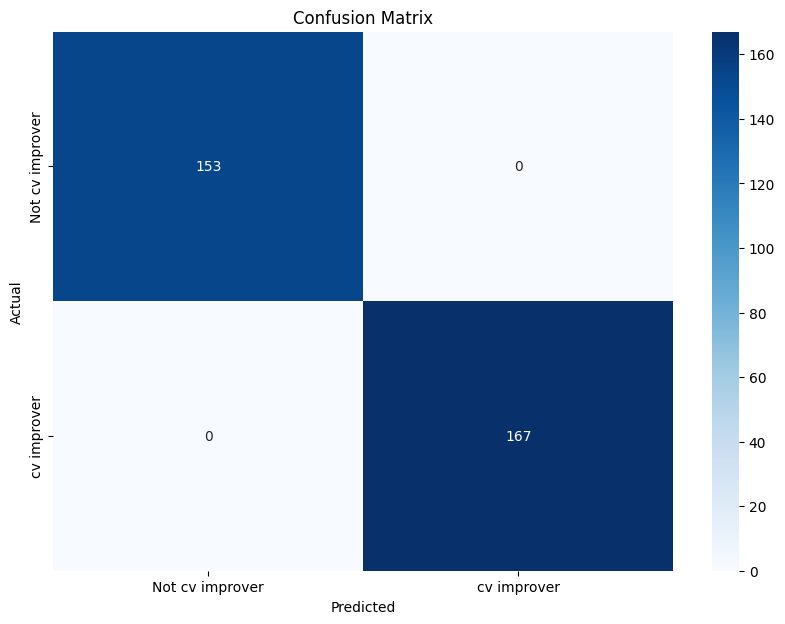

In [ ]:
# Confusion matrix and accuracy score
conf_matrix = confusion_matrix(y_test_cv, y_pred_cv)
accuracy = accuracy_score(y_test_cv, y_pred_cv)

print("\nConfusion Matrix:")
print(conf_matrix)

print("\nAccuracy Score:")
print(accuracy)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not cv improver', 'cv improver'], yticklabels=['Not cv improver', 'cv improver'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Define the paths
model_path = '/content/drive/MyDrive/Prompt-classifier/log_reg_cv_model.joblib'
vectorizer_path = '/content/drive/MyDrive/Prompt-classifier/tfidf_vectorizer_cv.joblib'

# Save the model and vectorizer
joblib.dump(log_reg_cv, model_path)
joblib.dump(tfidf_cv, vectorizer_path)

print("Model and vectorizer saved successfully in joblib format.")

Model and vectorizer saved successfully in joblib format.


## lm_improver binary logistic regression classifier

In [ ]:
# Check the class distribution
class_distribution = df['lm_improver'].value_counts()
print(class_distribution)

lm_improver
0    800
1    200
Name: count, dtype: int64


In [ ]:
# Balance the dataset using data augmentation
balanced_df_lm = augment_data(df, target_class='lm_improver')

In [ ]:
# Check the class distribution
class_distribution = balanced_df_lm['lm_improver'].value_counts()
print(class_distribution)

lm_improver
1    800
0    800
Name: count, dtype: int64


In [ ]:
# Apply text preprocessing
balanced_df_lm['input'] = balanced_df_lm['input'].apply(preprocess_text)

In [ ]:
# Save the preprocessed dataframe to Google Drive
balanced_df_lm.to_csv('/content/drive/MyDrive/Prompt-classifier/df_lm.csv', index=False)

In [ ]:
# Path to your CSV file
csv_file_path = '/content/drive/MyDrive/Prompt-classifier/df_lm.csv'

# Read the CSV file into a DataFrame
balanced_df_lm = pd.read_csv(csv_file_path)

In [ ]:
# Features and target variable for the 'best_jobs' class
X_lm = balanced_df_lm['input']
y_lm= balanced_df_lm['lm_improver']

# Split the data into training and testing sets
X_train_lm, X_test_lm, y_train_lm, y_test_lm = train_test_split(X_lm, y_lm, test_size=0.2, random_state=42)

# Convert text data into numerical features using TfidfVectorizer
tfidf_lm = TfidfVectorizer()
X_train_lm_tfidf = tfidf_cv.fit_transform(X_train_lm)
X_test_lm_tfidf = tfidf_cv.transform(X_test_lm)

# Train the logistic regression model
log_reg_lm = LogisticRegression()
log_reg_lm.fit(X_train_lm_tfidf, y_train_lm)

# Predict on the test set
y_pred_lm= log_reg_lm.predict(X_test_lm_tfidf)

# Evaluate the model
print(classification_report(y_test_lm, y_pred_lm))

# Print the class distribution after augmentation
print("Class distribution after augmentation:", Counter(y_train_lm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       164
           1       1.00      1.00      1.00       156

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320

Class distribution after augmentation: Counter({1: 644, 0: 636})



Confusion Matrix:
[[164   0]
 [  0 156]]

Accuracy Score:
1.0


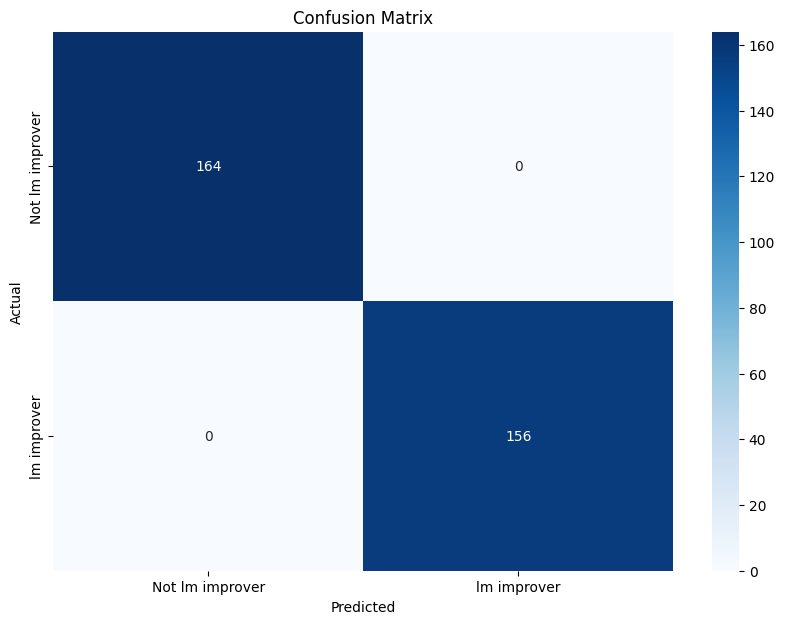

In [ ]:
# Confusion matrix and accuracy score
conf_matrix = confusion_matrix(y_test_lm, y_pred_lm)
accuracy = accuracy_score(y_test_lm, y_pred_lm)

print("\nConfusion Matrix:")
print(conf_matrix)

print("\nAccuracy Score:")
print(accuracy)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not lm improver', 'lm improver'], yticklabels=['Not lm improver', 'lm improver'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Define the paths
model_path = '/content/drive/MyDrive/Prompt-classifier/log_reg_lm_model.joblib'
vectorizer_path = '/content/drive/MyDrive/Prompt-classifier/tfidf_vectorizer_lm.joblib'

# Save the model and vectorizer
joblib.dump(log_reg_lm, model_path)
joblib.dump(tfidf_lm, vectorizer_path)

print("Model and vectorizer saved successfully in joblib format.")

Model and vectorizer saved successfully in joblib format.


## Interview-coaching binary logistic regression classifier

In [ ]:
# Check the class distribution
class_distribution = df['interview-coaching'].value_counts()
print(class_distribution)

interview-coaching
0    800
1    200
Name: count, dtype: int64


In [ ]:
# Balance the dataset using data augmentation
balanced_df_ic = augment_data(df, target_class='interview-coaching')

In [ ]:
# Check the class distribution
class_distribution = balanced_df_ic['interview-coaching'].value_counts()
print(class_distribution)

interview-coaching
0    800
1    800
Name: count, dtype: int64


In [ ]:
# Apply text preprocessing
balanced_df_ic['input'] = balanced_df_ic['input'].apply(preprocess_text)

In [ ]:
# Save the preprocessed dataframe to Google Drive
balanced_df_ic.to_csv('/content/drive/MyDrive/Prompt-classifier/df_ic.csv', index=False)

In [ ]:
# Path to your CSV file
csv_file_path = '/content/drive/MyDrive/Prompt-classifier/df_ic.csv'

# Read the CSV file into a DataFrame
balanced_df_ic = pd.read_csv(csv_file_path)

In [ ]:
# Features and target variable for the 'best_jobs' class
X_ic = balanced_df_ic['input']
y_ic= balanced_df_ic['interview-coaching']

# Split the data into training and testing sets
X_train_ic, X_test_ic, y_train_ic, y_test_ic = train_test_split(X_ic, y_ic, test_size=0.2, random_state=42)

# Convert text data into numerical features using TfidfVectorizer
tfidf_ic = TfidfVectorizer()
X_train_ic_tfidf = tfidf_ic.fit_transform(X_train_ic)
X_test_ic_tfidf = tfidf_ic.transform(X_test_ic)

# Train the logistic regression model
log_reg_ic = LogisticRegression()
log_reg_ic.fit(X_train_ic_tfidf, y_train_ic)

# Predict on the test set
y_pred_ic= log_reg_ic.predict(X_test_ic_tfidf)

# Evaluate the model
print(classification_report(y_test_ic, y_pred_ic))

# Print the class distribution after augmentation
print("Class distribution after augmentation:", Counter(y_train_ic))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       169
           1       1.00      1.00      1.00       151

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320

Class distribution after augmentation: Counter({1: 649, 0: 631})



Confusion Matrix:
[[169   0]
 [  0 151]]

Accuracy Score:
1.0


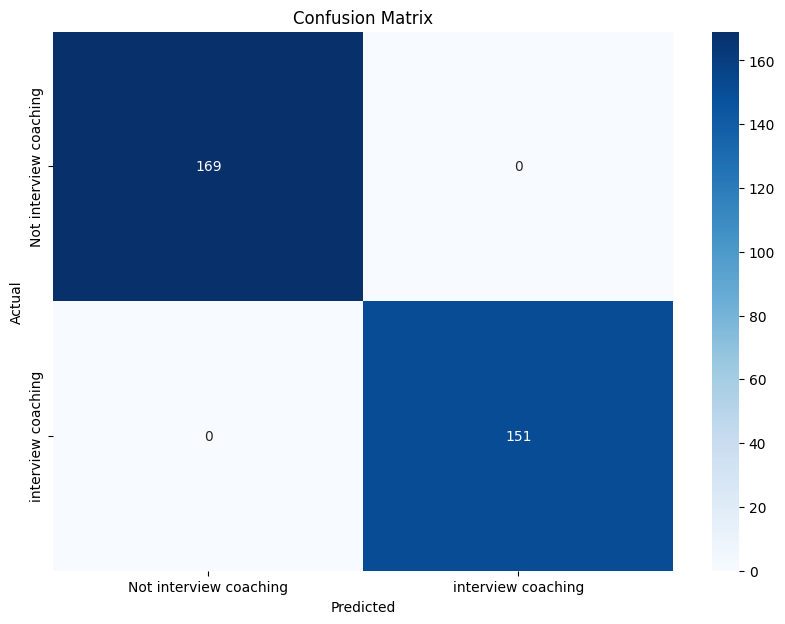

In [ ]:
# Confusion matrix and accuracy score
conf_matrix = confusion_matrix(y_test_ic, y_pred_ic)
accuracy = accuracy_score(y_test_ic, y_pred_ic)

print("\nConfusion Matrix:")
print(conf_matrix)

print("\nAccuracy Score:")
print(accuracy)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not interview coaching', 'interview coaching'], yticklabels=['Not interview coaching', 'interview coaching'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Define the paths
model_path = '/content/drive/MyDrive/Prompt-classifier/log_reg_ic_model.joblib'
vectorizer_path = '/content/drive/MyDrive/Prompt-classifier/tfidf_vectorizer_ic.joblib'

# Save the model and vectorizer
joblib.dump(log_reg_ic, model_path)
joblib.dump(tfidf_ic, vectorizer_path)

print("Model and vectorizer saved successfully in joblib format.")

Model and vectorizer saved successfully in joblib format.


## KO binary logistic regression classifier

In [ ]:
# Check the class distribution
class_distribution = df['KO'].value_counts()
print(class_distribution)

KO
0    800
1    200
Name: count, dtype: int64


In [ ]:
# Balance the dataset using data augmentation
balanced_df_ko = augment_data(df, target_class='KO')

In [ ]:
# Check the class distribution
class_distribution = balanced_df_ko['KO'].value_counts()
print(class_distribution)

KO
0    800
1    800
Name: count, dtype: int64


In [ ]:
# Apply text preprocessing
balanced_df_ko['input'] = balanced_df_ko['input'].apply(preprocess_text)

In [ ]:
# Save the preprocessed dataframe to Google Drive
balanced_df_ko.to_csv('/content/drive/MyDrive/Prompt-classifier/df_ko.csv', index=False)

In [ ]:
# Path to your CSV file
csv_file_path = '/content/drive/MyDrive/Prompt-classifier/df_ko.csv'

# Read the CSV file into a DataFrame
balanced_df_ko = pd.read_csv(csv_file_path)

In [ ]:
# Features and target variable for the 'best_jobs' class
X_ko= balanced_df_ko['input']
y_ko= balanced_df_ko['KO']

# Split the data into training and testing sets
X_train_ko, X_test_ko, y_train_ko, y_test_ko = train_test_split(X_ko, y_ko, test_size=0.2, random_state=42)

# Convert text data into numerical features using TfidfVectorizer
tfidf_ko = TfidfVectorizer()
X_train_ko_tfidf = tfidf_ko.fit_transform(X_train_ko)
X_test_ko_tfidf = tfidf_ko.transform(X_test_ko)

# Train the logistic regression model
log_reg_ko = LogisticRegression()
log_reg_ko.fit(X_train_ko_tfidf, y_train_ko)

# Predict on the test set
y_pred_ko= log_reg_ko.predict(X_test_ko_tfidf)

# Evaluate the model
print(classification_report(y_test_ko, y_pred_ko))

# Print the class distribution after augmentation
print("Class distribution after augmentation:", Counter(y_train_ko))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       156
           1       1.00      1.00      1.00       164

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320

Class distribution after augmentation: Counter({0: 644, 1: 636})



Confusion Matrix:
[[156   0]
 [  0 164]]

Accuracy Score:
1.0


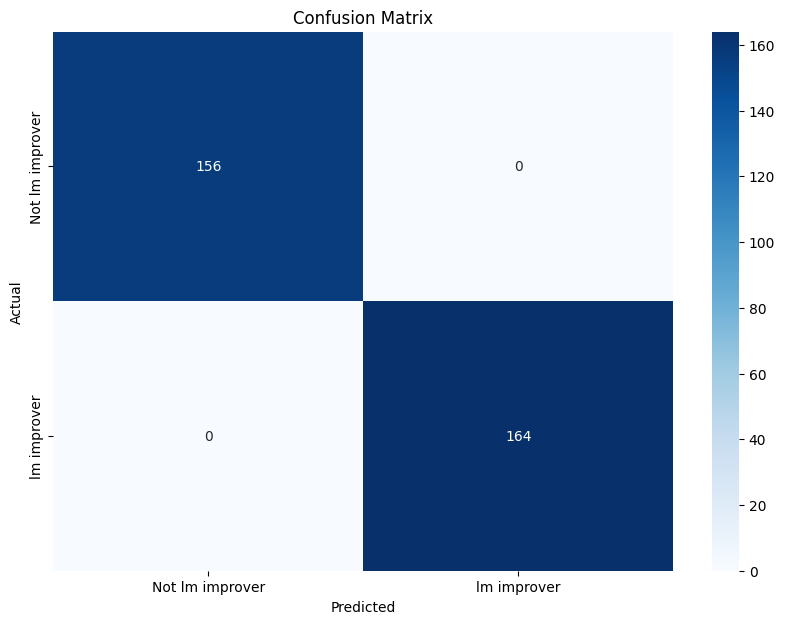

In [ ]:
# Confusion matrix and accuracy score
conf_matrix = confusion_matrix(y_test_ko, y_pred_ko)
accuracy = accuracy_score(y_test_ko, y_pred_ko)

print("\nConfusion Matrix:")
print(conf_matrix)

print("\nAccuracy Score:")
print(accuracy)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not lm improver', 'lm improver'], yticklabels=['Not lm improver', 'lm improver'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Define the paths
model_path = '/content/drive/MyDrive/Prompt-classifier/log_reg_ko_model.joblib'
vectorizer_path = '/content/drive/MyDrive/Prompt-classifier/tfidf_vectorizer_ko.joblib'

# Save the model and vectorizer
joblib.dump(log_reg_ko, model_path)
joblib.dump(tfidf_ko, vectorizer_path)

print("Model and vectorizer saved successfully in joblib format.")

Model and vectorizer saved successfully in joblib format.


# Prediction

In [ ]:
import pickle

# Common base path
base_path = '/content/drive/MyDrive/Prompt-classifier/'

# Directory paths
model_dir = base_path + 'log_models/'
vectorizer_dir = base_path + 'vectorizers/'

# Save models and vectorizers
model_vectorizer_pairs = [
    (log_reg_best_jobs, tfidf_bj, model_dir + 'log_reg_best_jobs_model.pkl', vectorizer_dir + 'tfidf_vectorizer_bj.pkl'),
    (log_reg_cv, tfidf_cv, model_dir + 'log_reg_cv_model.pkl', vectorizer_dir + 'tfidf_vectorizer_cv.pkl'),
    (log_reg_lm, tfidf_lm, model_dir + 'log_reg_lm_model.pkl', vectorizer_dir + 'tfidf_vectorizer_lm.pkl'),
    (log_reg_ic, tfidf_ic, model_dir + 'log_reg_ic_model.pkl', vectorizer_dir + 'tfidf_vectorizer_ic.pkl'),
    (log_reg_ko, tfidf_ko, model_dir + 'log_reg_ko_model.pkl', vectorizer_dir + 'tfidf_vectorizer_ko.pkl')
]

for model, vectorizer, model_path, vectorizer_path in model_vectorizer_pairs:
    with open(model_path, 'wb') as model_file:
        pickle.dump(model, model_file)
    with open(vectorizer_path, 'wb') as vectorizer_file:
        pickle.dump(vectorizer, vectorizer_file)

In [ ]:
import pickle

# Common base path
base_path = '/content/drive/MyDrive/Prompt-classifier/'

# Directory paths
model_dir = base_path + 'log_models/'
vectorizer_dir = base_path + 'vectorizers/'

# Load models and vectorizers
models = {}
vectorizers = {}

model_vectorizer_paths = [
    ('log_reg_best_jobs_model.pkl', 'tfidf_vectorizer_bj.pkl', 'best_jobs'),
    ('log_reg_cv_model.pkl', 'tfidf_vectorizer_cv.pkl', 'cv_improver'),
    ('log_reg_lm_model.pkl', 'tfidf_vectorizer_lm.pkl', 'lm_improver'),
    ('log_reg_ic_model.pkl', 'tfidf_vectorizer_ic.pkl', 'interview_coaching'),
    ('log_reg_ko_model.pkl', 'tfidf_vectorizer_ko.pkl', 'ko')
]

for model_file_name, vectorizer_file_name, label in model_vectorizer_paths:
    model_path = model_dir + model_file_name
    vectorizer_path = vectorizer_dir + vectorizer_file_name

    with open(model_path, 'rb') as model_file:
        models[label] = pickle.load(model_file)
    with open(vectorizer_path, 'rb') as vectorizer_file:
        vectorizers[label] = pickle.load(vectorizer_file)

In [ ]:
def train_model(data, target):
    X = data['input']
    y = data[target]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert text data into numerical features using TfidfVectorizer
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Train the logistic regression model
    model = LogisticRegression()
    model.fit(X_train_tfidf, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test_tfidf)

    # Evaluate the model
    print(f"Classification report for {target}:")
    print(classification_report(y_test, y_pred))

    # Print the class distribution after augmentation
    print(f"Class distribution after augmentation for {target}:", Counter(y_train))

    return model, vectorizer

In [ ]:
import pickle

# Define the base path for saving models and vectorizers
base_path = '/content/drive/MyDrive/Prompt-classifier/'

# Directory paths
model_dir = base_path + 'log_models/'
vectorizer_dir = base_path + 'vectorizers/'

# Train models and vectorizers for each class
model_vectorizer_pairs = {
    'best_jobs': train_model(balanced_df_bj, 'best_jobs'),
    'cv_improver': train_model(balanced_df_cv, 'cv_improver'),
    'lm_improver': train_model(balanced_df_lm, 'lm_improver'),
    'interview_coaching': train_model(balanced_df_ic, 'interview-coaching'),
    'ko': train_model(balanced_df_ko, 'KO')
}

# Save each model and vectorizer
for label, (model, vectorizer) in model_vectorizer_pairs.items():
    model_path = model_dir + f'log_reg_{label}_model.pkl'
    vectorizer_path = vectorizer_dir + f'tfidf_vectorizer_{label}.pkl'

    with open(model_path, 'wb') as model_file:
        pickle.dump(model, model_file)

    with open(vectorizer_path, 'wb') as vectorizer_file:
        pickle.dump(vectorizer, vectorizer_file)

print("Models and vectorizers saved successfully.")


Classification report for best_jobs:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       154
           1       1.00      1.00      1.00       166

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320

Class distribution after augmentation for best_jobs: Counter({0: 646, 1: 634})
Classification report for cv_improver:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       167

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320

Class distribution after augmentation for cv_improver: Counter({0: 647, 1: 633})
Classification report for lm_improver:
              precision    recall  f1-score   support

           0    

In [ ]:
def predict_class(input_text, model, vectorizer):
    # Preprocess text
    input_text_processed = preprocess_text(input_text)
    # Vectorize input text
    input_text_tfidf = vectorizer.transform([input_text_processed])
    # Predict probabilities
    probabilities = model.predict_proba(input_text_tfidf)
    # Predict class
    predicted_class = model.predict(input_text_tfidf)
    return predicted_class[0], probabilities[0]

def predict_all_classes(input_text):
    results = {}
    for label, (model, vectorizer) in model_vectorizer_pairs.items():
        predicted_class, probabilities = predict_class(input_text, model, vectorizer)
        print(f"Label: {label}, Prediction: {predicted_class}, Probabilities: {probabilities}")  # Debug print
        if predicted_class == 1:
            results[label] = "detected"
    return results

def generate_output(input_text):
    predictions = predict_all_classes(input_text)
    output_parts = []

    if 'cv_improver' in predictions:
        output_parts.append("améliorer ton CV")
    if 'lm_improver' in predictions:
        output_parts.append("ta lettre de motivation")
    if 'interview_coaching' in predictions:
        output_parts.append("un coaching d'entretien")
    if 'best_jobs' in predictions:
        output_parts.append("les meilleures offres d'emploi")

    print(f"Output Parts: {output_parts}")  # Debug print

    if output_parts:
        if len(output_parts) > 1:
            final_output = f"D'accord, j'ai compris que tu as besoin d'aide pour {', '.join(output_parts[:-1])} et {output_parts[-1]}."
        else:
            final_output = f"D'accord, j'ai compris que tu as besoin d'aide pour {output_parts[0]}."
    else:
        final_output = "D'accord, je n'ai pas détecté de besoin spécifique."

    return final_output

# Example usage
input_prompt_1 = "Je cherche des conseils pour améliorer mon CV."
final_output_1 = generate_output(input_prompt_1)
print(final_output_1)  # Expected: "D'accord, j'ai compris que tu as besoin d'aide pour améliorer ton CV."

input_prompt_2 = "Je cherche des conseils pour améliorer mon CV et ma lettre de motivation."
final_output_2 = generate_output(input_prompt_2)
print(final_output_2)  # Expected: "D'accord, j'ai compris que tu as besoin d'aide pour améliorer ton CV et ta lettre de motivation."


Label: best_jobs, Prediction: 0, Probabilities: [0.90476152 0.09523848]
Label: cv_improver, Prediction: 1, Probabilities: [0.30243245 0.69756755]
Label: lm_improver, Prediction: 0, Probabilities: [0.95492126 0.04507874]
Label: interview_coaching, Prediction: 0, Probabilities: [0.98481613 0.01518387]
Label: ko, Prediction: 0, Probabilities: [0.7862417 0.2137583]
Output Parts: ['améliorer ton CV']
D'accord, j'ai compris que tu as besoin d'aide pour améliorer ton CV.
Label: best_jobs, Prediction: 0, Probabilities: [0.98081455 0.01918545]
Label: cv_improver, Prediction: 0, Probabilities: [0.78714082 0.21285918]
Label: lm_improver, Prediction: 1, Probabilities: [0.41258721 0.58741279]
Label: interview_coaching, Prediction: 0, Probabilities: [0.9954215 0.0045785]
Label: ko, Prediction: 0, Probabilities: [0.96365599 0.03634401]
Output Parts: ['ta lettre de motivation']
D'accord, j'ai compris que tu as besoin d'aide pour ta lettre de motivation.


In [ ]:
# Example usage
input_prompt_1 = "Je cherche des conseils pour améliorer mon CV."
final_output_1 = generate_output(input_prompt_1)
print(final_output_1)  # Expected: "D'accord, j'ai compris que tu as besoin d'aide pour améliorer ton CV."

input_prompt_2 = "Je cherche des conseils pour améliorer mon CV et ma lettre de motivation."
final_output_2 = generate_output(input_prompt_2)
print(final_output_2)  # Expected: "D'accord, j'ai compris que tu as besoin d'aide pour améliorer ton CV et ta lettre de motivation."


Label: best_jobs, Prediction: 0, Probabilities: [0.90476152 0.09523848]
Label: cv_improver, Prediction: 1, Probabilities: [0.30243245 0.69756755]
Label: lm_improver, Prediction: 0, Probabilities: [0.95492126 0.04507874]
Label: interview_coaching, Prediction: 0, Probabilities: [0.98481613 0.01518387]
Label: ko, Prediction: 0, Probabilities: [0.7862417 0.2137583]
Output Parts: ['améliorer ton CV']
D'accord, j'ai compris que tu as besoin d'aide pour améliorer ton CV.
Label: best_jobs, Prediction: 0, Probabilities: [0.98081455 0.01918545]
Label: cv_improver, Prediction: 0, Probabilities: [0.78714082 0.21285918]
Label: lm_improver, Prediction: 1, Probabilities: [0.41258721 0.58741279]
Label: interview_coaching, Prediction: 0, Probabilities: [0.9954215 0.0045785]
Label: ko, Prediction: 0, Probabilities: [0.96365599 0.03634401]
Output Parts: ['ta lettre de motivation']
D'accord, j'ai compris que tu as besoin d'aide pour ta lettre de motivation.


In [ ]:
def predict_class(input_text, model, vectorizer):
    # Preprocess text
    input_text_processed = preprocess_text(input_text)
    # Vectorize input text
    input_text_tfidf = vectorizer.transform([input_text_processed])
    # Predict probabilities
    probabilities = model.predict_proba(input_text_tfidf)
    # Predict class
    predicted_class = model.predict(input_text_tfidf)
    return predicted_class[0], probabilities[0]

def predict_all_classes(input_text):
    results = {}
    for label in models:
        model = models[label]
        vectorizer = vectorizers[label]
        predicted_class, probabilities = predict_class(input_text, model, vectorizer)
        print(f"Label: {label}, Prediction: {predicted_class}, Probabilities: {probabilities}")  # Debug print
        if predicted_class == 1:
            results[label] = "detected"
    return results

def generate_output(input_text):
    predictions = predict_all_classes(input_text)
    output_parts = []

    if 'cv_improver' in predictions:
        output_parts.append("améliorer ton CV")
    if 'lm_improver' in predictions:
        output_parts.append("ta lettre de motivation")
    if 'interview_coaching' in predictions:
        output_parts.append("un coaching d'entretien")
    if 'best_jobs' in predictions:
        output_parts.append("les meilleures offres d'emploi")

    print(f"Output Parts: {output_parts}")  # Debug print

    if output_parts:
        if len(output_parts) > 1:
            final_output = f"D'accord, j'ai compris que tu as besoin d'aide pour {', '.join(output_parts[:-1])} et {output_parts[-1]}."
        else:
            final_output = f"D'accord, j'ai compris que tu as besoin d'aide pour {output_parts[0]}."
    else:
        final_output = "D'accord, je n'ai pas détecté de besoin spécifique."

    return final_output

# Example usage
input_prompt_1 = "Je cherche des conseils pour améliorer mon CV."
final_output_1 = generate_output(input_prompt_1)
print(final_output_1)  # Expected: "D'accord, j'ai compris que tu as besoin d'aide pour améliorer ton CV."

input_prompt_2 = "Je cherche des conseils pour améliorer mon CV et ma lettre de motivation."
final_output_2 = generate_output(input_prompt_2)
print(final_output_2)  # Expected: "D'accord, j'ai compris que tu as besoin d'aide pour améliorer ton CV et ta lettre de motivation."

Label: best_jobs, Prediction: 0, Probabilities: [0.90476152 0.09523848]


ValueError: X has 562 features, but LogisticRegression is expecting 569 features as input.

# Using deep learning models : Bilstm with ovr approach

In [ ]:
import pandas as pd

# Paths to your CSV files
csv_paths = {
    'best_jobs': '/content/drive/MyDrive/Prompt-classifier/df_bj.csv',
    'cv_improver': '/content/drive/MyDrive/Prompt-classifier/df_cv.csv',
    'lm_improver': '/content/drive/MyDrive/Prompt-classifier/df_lm.csv',
    'interview-coaching': '/content/drive/MyDrive/Prompt-classifier/df_ic.csv',
    'KO': '/content/drive/MyDrive/Prompt-classifier/df_ko.csv'
}

# Load the datasets into dataframes
datasets = {label: pd.read_csv(path) for label, path in csv_paths.items()}


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# Tokenize and pad sequences for each class
maxlen = 150
tokenizers = {}
padded_sequences = {}
average_lengths = {}
max_lengths = {}
min_lengths = {}
percentage_coverages = {}

for label, df in datasets.items():
    prompts = list(df['input'])
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(prompts)
    tokenizers[label] = tokenizer

    sequences = tokenizer.texts_to_sequences(prompts)
    padded_sequences[label] = pad_sequences(sequences, maxlen=maxlen)

    # Calculate sequence lengths
    sequence_lengths = [len(seq) for seq in sequences]
    average_lengths[label] = np.mean(sequence_lengths)
    max_lengths[label] = np.max(sequence_lengths)
    min_lengths[label] = np.min(sequence_lengths)

    num_sequences_covered = sum(1 for length in sequence_lengths if length <= maxlen)
    percentage_coverages[label] = (num_sequences_covered / len(sequence_lengths)) * 100

# Print statistics
for label in datasets.keys():
    print(f'{label} - UNIQUE TOKENS: {len(tokenizers[label].word_index)}')
    print(f'AVERAGE SEQUENCE LENGTH: {average_lengths[label]:.2f}')
    print(f'MAXIMUM SEQUENCE LENGTH: {max_lengths[label]}')
    print(f'MINIMUM SEQUENCE LENGTH: {min_lengths[label]}')
    print(f'PERCENTAGE OF SEQUENCES COVERED BY MAX LENGTH {maxlen}: {percentage_coverages[label]:.2f}%\n')


best_jobs - UNIQUE TOKENS: 576
AVERAGE SEQUENCE LENGTH: 9.28
MAXIMUM SEQUENCE LENGTH: 29
MINIMUM SEQUENCE LENGTH: 3
PERCENTAGE OF SEQUENCES COVERED BY MAX LENGTH 150: 100.00%

cv_improver - UNIQUE TOKENS: 592
AVERAGE SEQUENCE LENGTH: 9.52
MAXIMUM SEQUENCE LENGTH: 29
MINIMUM SEQUENCE LENGTH: 3
PERCENTAGE OF SEQUENCES COVERED BY MAX LENGTH 150: 100.00%

lm_improver - UNIQUE TOKENS: 579
AVERAGE SEQUENCE LENGTH: 9.85
MAXIMUM SEQUENCE LENGTH: 29
MINIMUM SEQUENCE LENGTH: 3
PERCENTAGE OF SEQUENCES COVERED BY MAX LENGTH 150: 100.00%

interview-coaching - UNIQUE TOKENS: 612
AVERAGE SEQUENCE LENGTH: 10.72
MAXIMUM SEQUENCE LENGTH: 30
MINIMUM SEQUENCE LENGTH: 3
PERCENTAGE OF SEQUENCES COVERED BY MAX LENGTH 150: 100.00%

KO - UNIQUE TOKENS: 597
AVERAGE SEQUENCE LENGTH: 7.61
MAXIMUM SEQUENCE LENGTH: 29
MINIMUM SEQUENCE LENGTH: 3
PERCENTAGE OF SEQUENCES COVERED BY MAX LENGTH 150: 100.00%



In [ ]:
import gensim.downloader as api
import numpy as np

# Load pre-trained FastText model
fasttext_model = api.load('fasttext-wiki-news-subwords-300')

[=-------------------------------------------------] 2.7% 26.1/958.4MB downloaded

KeyboardInterrupt: 

In [ ]:
def create_embedding_matrix(tokenizer, embedding_model):
    """Create embedding matrix from pre-trained word embedding model."""
    vocab_size = len(tokenizer.word_index)
    embedding_dim = len(embedding_model['king'])  # Assuming 'king' is in the model vocabulary

    # Initialize embedding matrix
    embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))

    # Fill embedding matrix
    for word, i in tokenizer.word_index.items():
        if word in embedding_model:
            embedding_matrix[i] = embedding_model[word]
        else:
            # Initialize random vector for out-of-vocabulary words
            embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return embedding_matrix

In [ ]:
embedding_matrices = {label: create_embedding_matrix(tokenizer, fasttext_model) for label, tokenizer in tokenizers.items()}

# Save embedding matrices
embedding_directory = '/content/drive/MyDrive/Prompt-classifier/embedding_matrices'
for label, embedding_matrix in embedding_matrices.items():
    fasttext_embedding_path = f'{embedding_directory}/{label}_fasttext_embedding_matrix.npy'
    np.save(fasttext_embedding_path, embedding_matrix)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from sklearn.model_selection import train_test_split

# Define and train BiLSTM model
def train_bilstm_model(X, y, embedding_matrix, maxlen, model_path):
    vocab_size = embedding_matrix.shape[0]

    embedding_dim = embedding_matrix.shape[1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

    # Define the model
    Bilstm_model = Sequential()
    Bilstm_model.add(Embedding(input_dim=vocab_size,
                               output_dim=embedding_dim,
                               weights=[embedding_matrix],
                               input_length=maxlen,
                               trainable=False))
    Bilstm_model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
    Bilstm_model.add(Bidirectional(LSTM(units=64)))
    Bilstm_model.add(Dense(units=1, activation='sigmoid'))

    # Compile the model
    Bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Print model summary
    Bilstm_model.summary()

    # Train the model
    history = Bilstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

    # Save the model
    Bilstm_model.save(model_path)

    return Bilstm_model

# Train models for each class
for label, df in datasets.items():
    y = df[label]
    X = padded_sequences[label]
    embedding_matrix = embedding_matrices[label]
    model_path = f'/content/drive/MyDrive/Prompt-classifier/Bilstm_models/{label}_bi_lstm_fasttext_model.h5'
    train_bilstm_model(X, y, embedding_matrix, maxlen, model_path)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 300)          173100    
                                                                 
 bidirectional_10 (Bidirect  (None, 150, 256)          439296    
 ional)                                                          
                                                                 
 bidirectional_11 (Bidirect  (None, 128)               164352    
 ional)                                                          
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 776877 (2.96 MB)
Trainable params: 603777 (2.30 MB)
Non-trainable params: 173100 (676.17 KB)
_________________________________________________________________
Epoch 1/10
32

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 150, 300)          177900    
                                                                 
 bidirectional_12 (Bidirect  (None, 150, 256)          439296    
 ional)                                                          
                                                                 
 bidirectional_13 (Bidirect  (None, 128)               164352    
 ional)                                                          
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 781677 (2.98 MB)
Trainable params: 603777 (2.30 MB)
Non-trainable params: 177900 (694.92 KB)
_________________________________________________________________
Epoch 1/10
32

In [ ]:
from keras.models import load_model

# Function to load models and embedding matrices
def load_models_and_embeddings(labels, model_dir, embedding_dir):
    models = {}
    embeddings = {}
    for label in labels:
        model_path = f'{model_dir}/{label}_bi_lstm_fasttext_model.h5'
        embedding_path = f'{embedding_dir}/{label}_fasttext_embedding_matrix.npy'

        models[label] = load_model(model_path)
        embeddings[label] = np.load(embedding_path)

    return models, embeddings

labels = ['best_jobs', 'cv_improver', 'lm_improver', 'interview-coaching', 'KO']
model_dir = '/content/drive/MyDrive/Prompt-classifier/Bilstm_models'
embedding_dir = '/content/drive/MyDrive/Prompt-classifier/embedding_matrices'
models, embeddings = load_models_and_embeddings(labels, model_dir, embedding_dir)

# Function to preprocess text and make predictions
def preprocess_text_for_prediction(text, tokenizer, maxlen):
    preprocessed_text = preprocess_text(text)
    sequences = tokenizer.texts_to_sequences([preprocessed_text])
    padded_sequence = pad_sequences(sequences, maxlen=maxlen)
    return padded_sequence

def predict_classes(input_text, models, tokenizers, maxlen):
    results = {}
    for label in models.keys():
        padded_sequence = preprocess_text_for_prediction(input_text, tokenizers[label], maxlen)
        predicted_class = models[label].predict(padded_sequence)
        results[label] = predicted_class[0][0]
    return results



In [ ]:
input_prompt = "Je cherche des conseils pour améliorer ma lettre de motivation."
predictions = predict_classes(input_prompt, models, tokenizers, maxlen)
print(predictions)

1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step
{'best_jobs': 0.019456644, 'cv_improver': 1.834728e-06, 'lm_improver': 0.9967493, 'interview-coaching': 0.0017940582, 'KO': 0.0022075968}


In [ ]:
input_prompt = "Je cherche des conseils pour améliorer ma lettre de motivation et mon cv."
predictions = predict_classes(input_prompt, models, tokenizers, maxlen)
print(predictions)

1/1 [==============================] - 0s 81ms/step
{'best_jobs': 0.007270094, 'cv_improver': 0.91570336, 'lm_improver': 0.0004672436, 'interview-coaching': 0.0010769268, 'KO': 0.0006284437}


# Multi-label classifier

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from keras.preprocessing.text import Tokenizer
import gensim.downloader as api

# Load data
csv_file_path = '/content/drive/MyDrive/Prompt-classifier/edited_preprocessed_data.csv'
df = pd.read_csv(csv_file_path)

# Split data into features and labels
X = df['input'].values
y = df[['best_jobs', 'cv_improver', 'lm_improver', 'interview-coaching', 'KO']].values

# Ensure labels are lists of strings
label_columns = df.columns[2:]
y = [list(label_columns[row.astype(bool)]) for row in y]

# Tokenize the input data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

maxlen = 150  # Assuming max length based on previous context
X_padded = pad_sequences(sequences, maxlen=maxlen)

# Initialize MultiLabelBinarizer and transform labels
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(y)

embedding_matrix = create_embedding_matrix(tokenizer, fasttext_model)

# Define the BiLSTM model
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_matrix.shape[1],
                    weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dense(units=len(mlb.classes_), activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/10
20/20 [==============================] - 9s 104ms/step - loss: 0.5451 - accuracy: 0.2438 - val_loss: 0.4610 - val_accuracy: 0.3688
Epoch 2/10
20/20 [==============================] - 0s 25ms/step - loss: 0.3840 - accuracy: 0.6297 - val_loss: 0.3006 - val_accuracy: 0.7375
Epoch 3/10
20/20 [==============================] - 1s 26ms/step - loss: 0.2337 - accuracy: 0.8313 - val_loss: 0.1835 - val_accuracy: 0.8750
Epoch 4/10
20/20 [==============================] - 0s 25ms/step - loss: 0.1414 - accuracy: 0.9062 - val_loss: 0.1094 - val_accuracy: 0.9250
Epoch 5/10
20/20 [==============================] - 1s 26ms/step - loss: 0.0866 - accuracy: 0.9469 - val_loss: 0.0710 - val_accuracy: 0.9625
Epoch 6/10
20/20 [==============================] - 0s 25ms/step - loss: 0.0582 - accuracy: 0.9734 - val_loss: 0.0510 - val_accuracy: 0.9688
Epoch 7/10
20/20 [==============================] - 1s 26ms/step - loss: 0.0421 - accuracy: 0.9812 - val_loss: 0.0663 - val_accuracy: 0.9563
Epoch 8/10
2

In [ ]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

7/7 [==============================] - 4s 27ms/step - loss: 0.0263 - accuracy: 0.9900
Test Score: 0.026310674846172333
Test Accuracy: 0.9900000095367432


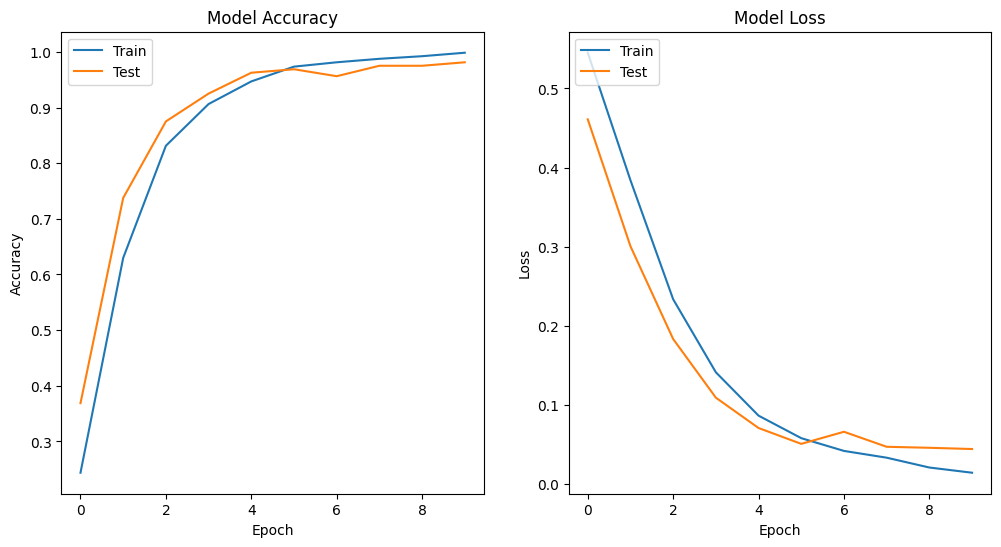

In [ ]:
# Plotting accuracy and loss
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Show plots
plt.show()


In [ ]:
def predict_multiple_needs(input_text, model, tokenizer, mlb, maxlen):
    # Preprocess the input text
    input_text_processed = preprocess_text(input_text)

    # Tokenize and pad the input text
    sequence = tokenizer.texts_to_sequences([input_text_processed])
    padded_sequence = pad_sequences(sequence, maxlen=maxlen)

    # Predict probabilities
    probabilities = model.predict(padded_sequence)[0]

    # Thresholding at 0.5 to determine the class
    predicted_classes = (probabilities >= 0.5).astype(int)

    # Convert predictions to class labels
    predicted_labels = mlb.inverse_transform(np.array([predicted_classes]))[0]

    # Create a dictionary of class probabilities
    class_probabilities = {mlb.classes_[i]: probabilities[i] for i in range(len(mlb.classes_))}

    return predicted_labels, class_probabilities

1/1 [==============================] - 0s 106ms/step
Predicted classes: ('cv_improver',)
Probabilities: {'KO': 0.23363884, 'best_jobs': 0.0036458257, 'cv_improver': 0.60777825, 'interview-coaching': 0.0013792765, 'lm_improver': 0.012371753}


In [ ]:
# Example usage
input_prompt = "Je cherche des conseils pour améliorer ma lettre de motivation et mon CV."
predicted_classes, probabilities = predict_multiple_needs(input_prompt, model, tokenizer, mlb, maxlen)
print(f'Predicted classes: {predicted_classes}')
print(f'Probabilities: {probabilities}')